In [1]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from hessian_utils import *
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 
import time

# PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
# How to do this?
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
%matplotlib inline


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_X = cifar_trainset.data
train_y = cifar_trainset.targets
test_X = cifar_testset.data
test_y = cifar_testset.targets

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(16*8*8, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*8*8)
        x = self.linear(x)
        return x

In [6]:
train_X = torch.tensor(train_X).permute(0, 3, 1, 2)
test_X = torch.tensor(test_X).permute(0, 3, 1, 2)

train_X = (torch.tensor(train_X, dtype=torch.float32)/255).to(device)
test_X = (torch.tensor(test_X, dtype=torch.float32)/255).to(device)
train_y = (torch.tensor(train_y, dtype=torch.int64)).to(device)
test_y = (torch.tensor(test_y, dtype=torch.int64)).to(device)
val_x = train_X[:1000]
val_y = train_y[:1000]
x_samples = train_X[:50]
y_samples = train_y[:50]

/tmp/ipykernel_56223/1387114815.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = (torch.tensor(train_X, dtype=torch.float32)/255).to(device)


/tmp/ipykernel_56223/1387114815.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_X = (torch.tensor(test_X, dtype=torch.float32)/255).to(device)


In [7]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X, train_y),
    batch_size=32, shuffle=True)
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
num_batches = 10
loader = []
for i, (data, target) in enumerate(dataloader):
    if i == num_batches:
        break
    loader.append((data, target))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1177.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


/teamspace/studios/this_studio/DeepHessian/PyHessian/density_plot.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


Epoch 0, step 0, train_loss 2.2929527759552, test_loss 2.312154531478882
Epoch 0, step 500, train_loss 1.6040856838226318, test_loss 1.8560289144515991
Epoch 0, step 1000, train_loss 1.490931749343872, test_loss 1.6993610858917236
Epoch 0, step 1500, train_loss 1.6180073022842407, test_loss 1.6043707132339478
Epoch 1, step 0, train_loss 1.6445876359939575, test_loss 1.5245716571807861
Epoch 1, step 500, train_loss 1.4939478635787964, test_loss 1.5412486791610718
Epoch 1, step 1000, train_loss 1.5092068910598755, test_loss 1.465498447418213
Epoch 1, step 1500, train_loss 1.7164188623428345, test_loss 1.4403128623962402
Epoch 2, step 0, train_loss 1.6568464040756226, test_loss 1.4219454526901245
Epoch 2, step 500, train_loss 1.4679219722747803, test_loss 1.4294867515563965
Epoch 2, step 1000, train_loss 1.543792724609375, test_loss 1.3953584432601929
Epoch 2, step 1500, train_loss 1.1789467334747314, test_loss 1.3727227449417114
Epoch 3, step 0, train_loss 1.7905696630477905, test_loss 1

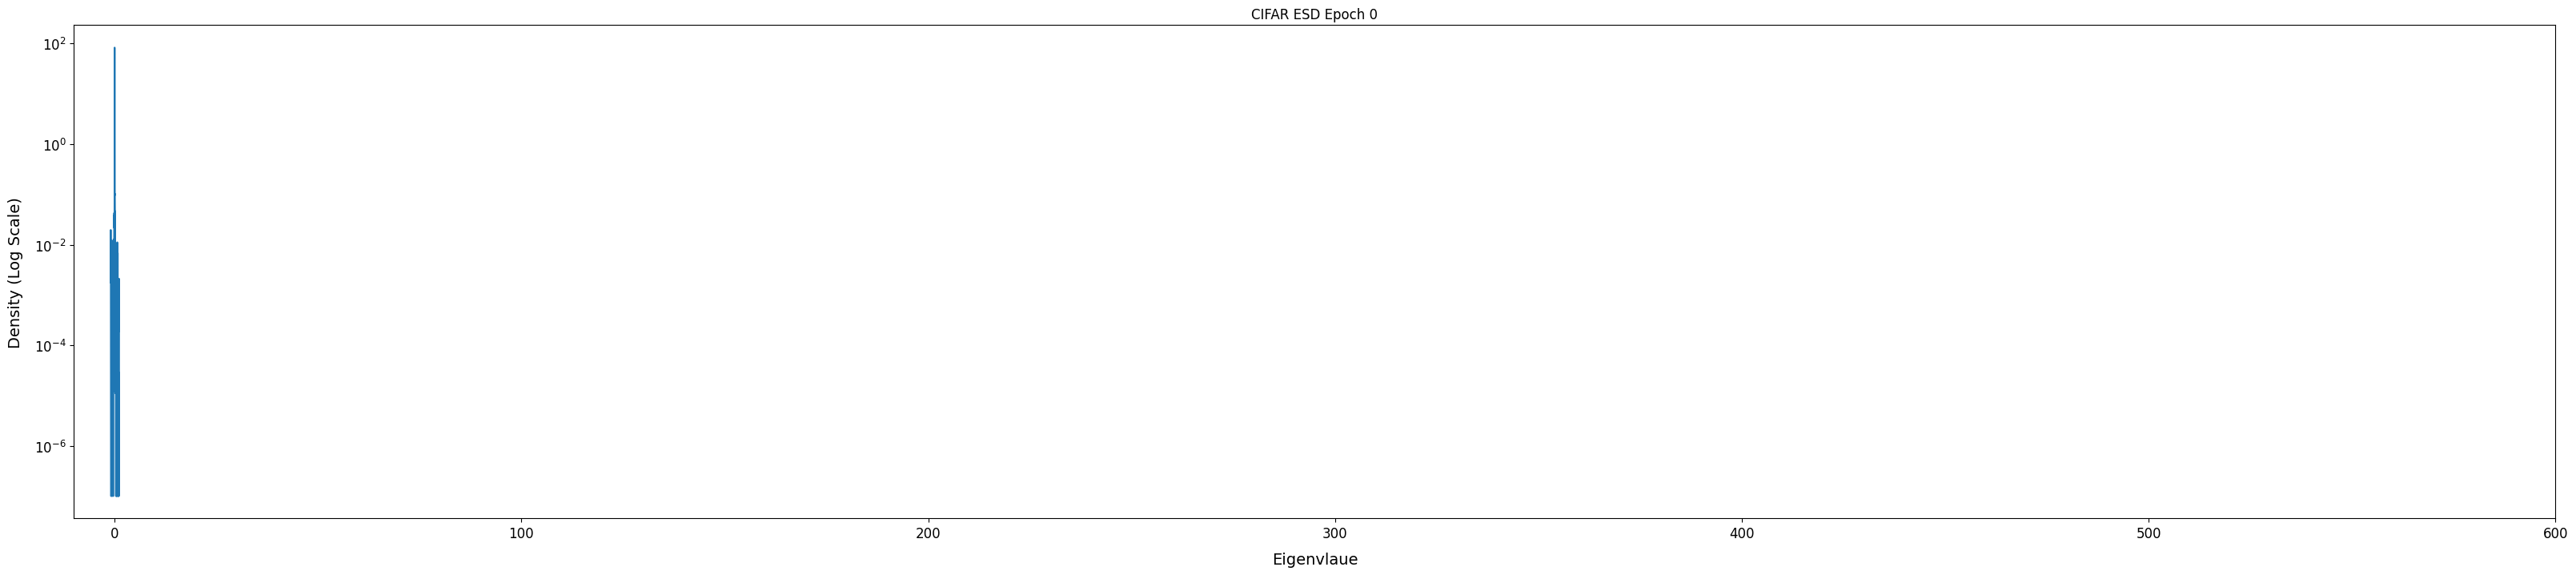

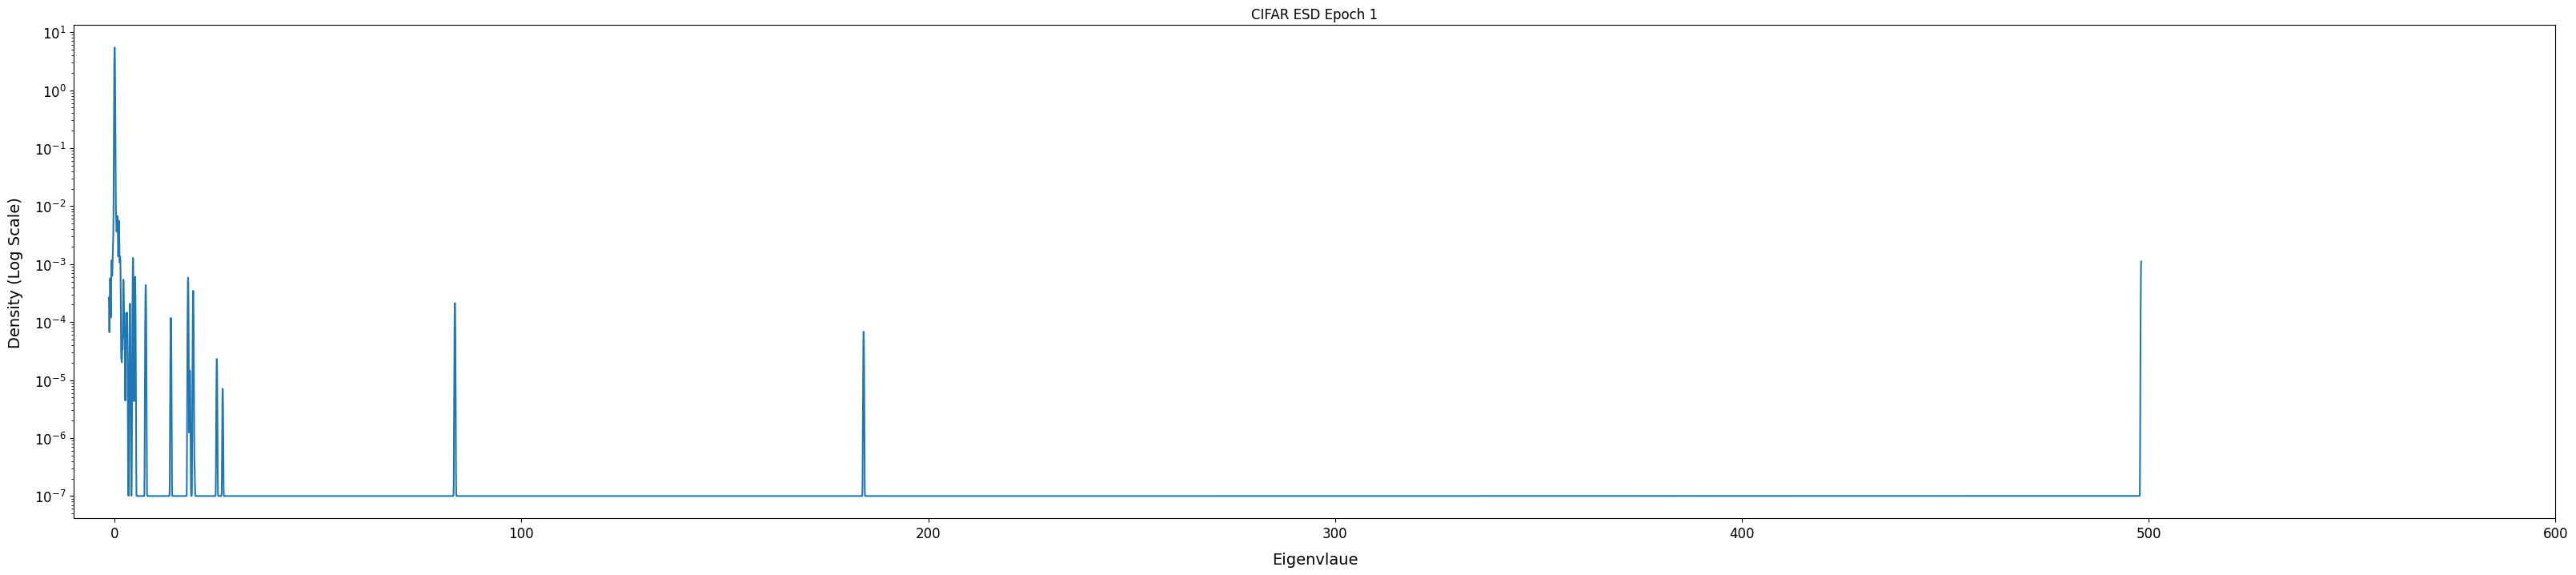

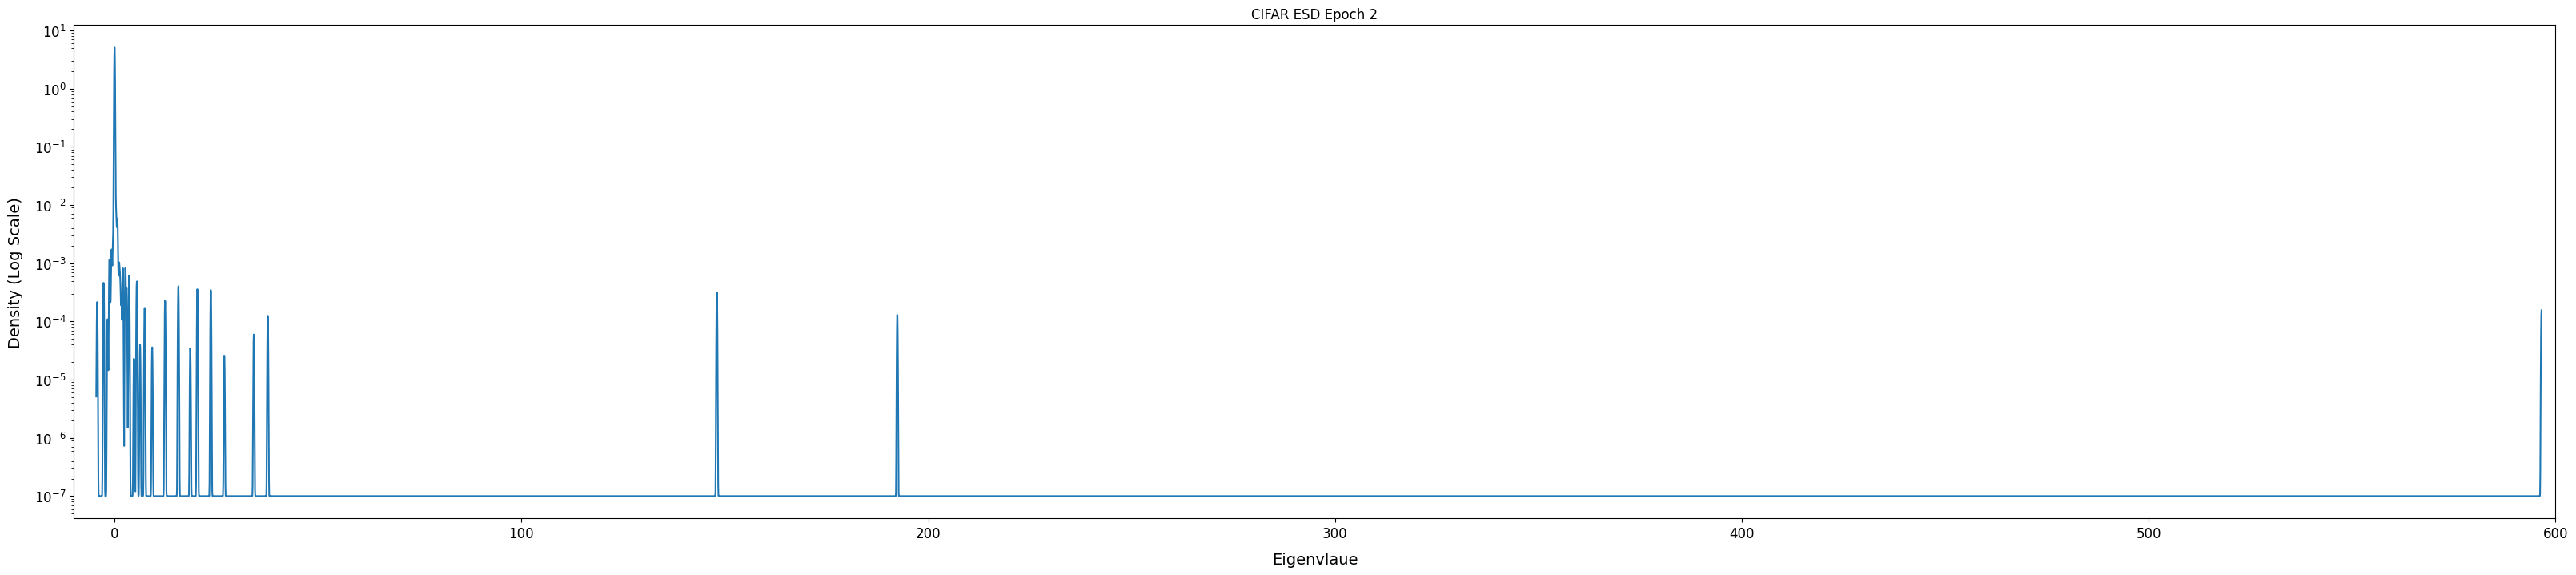

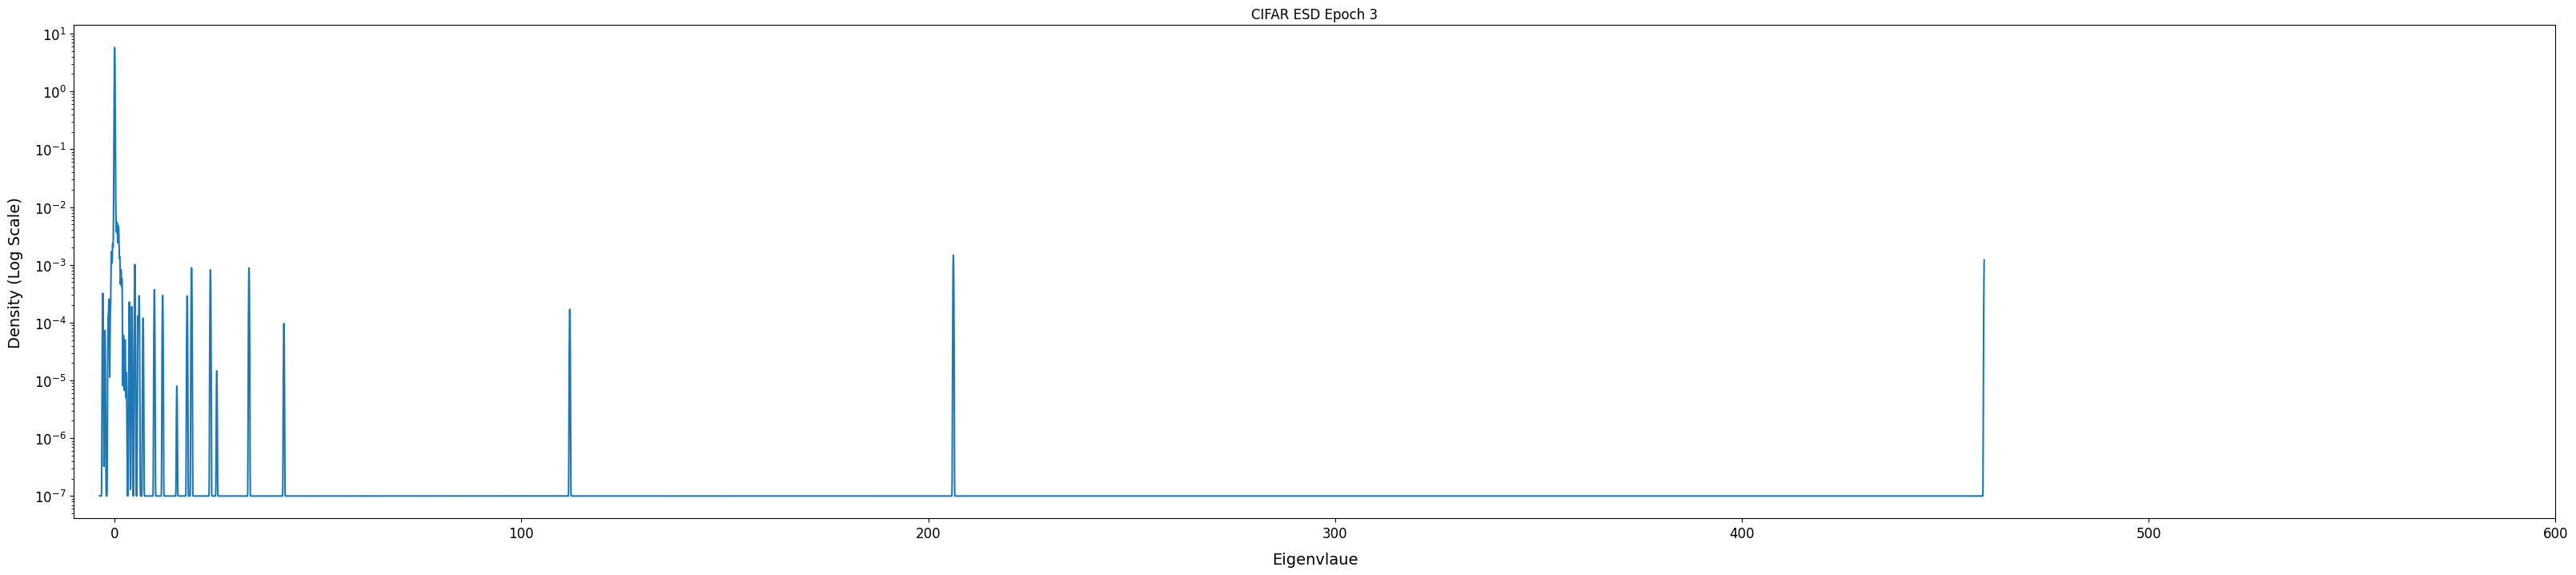

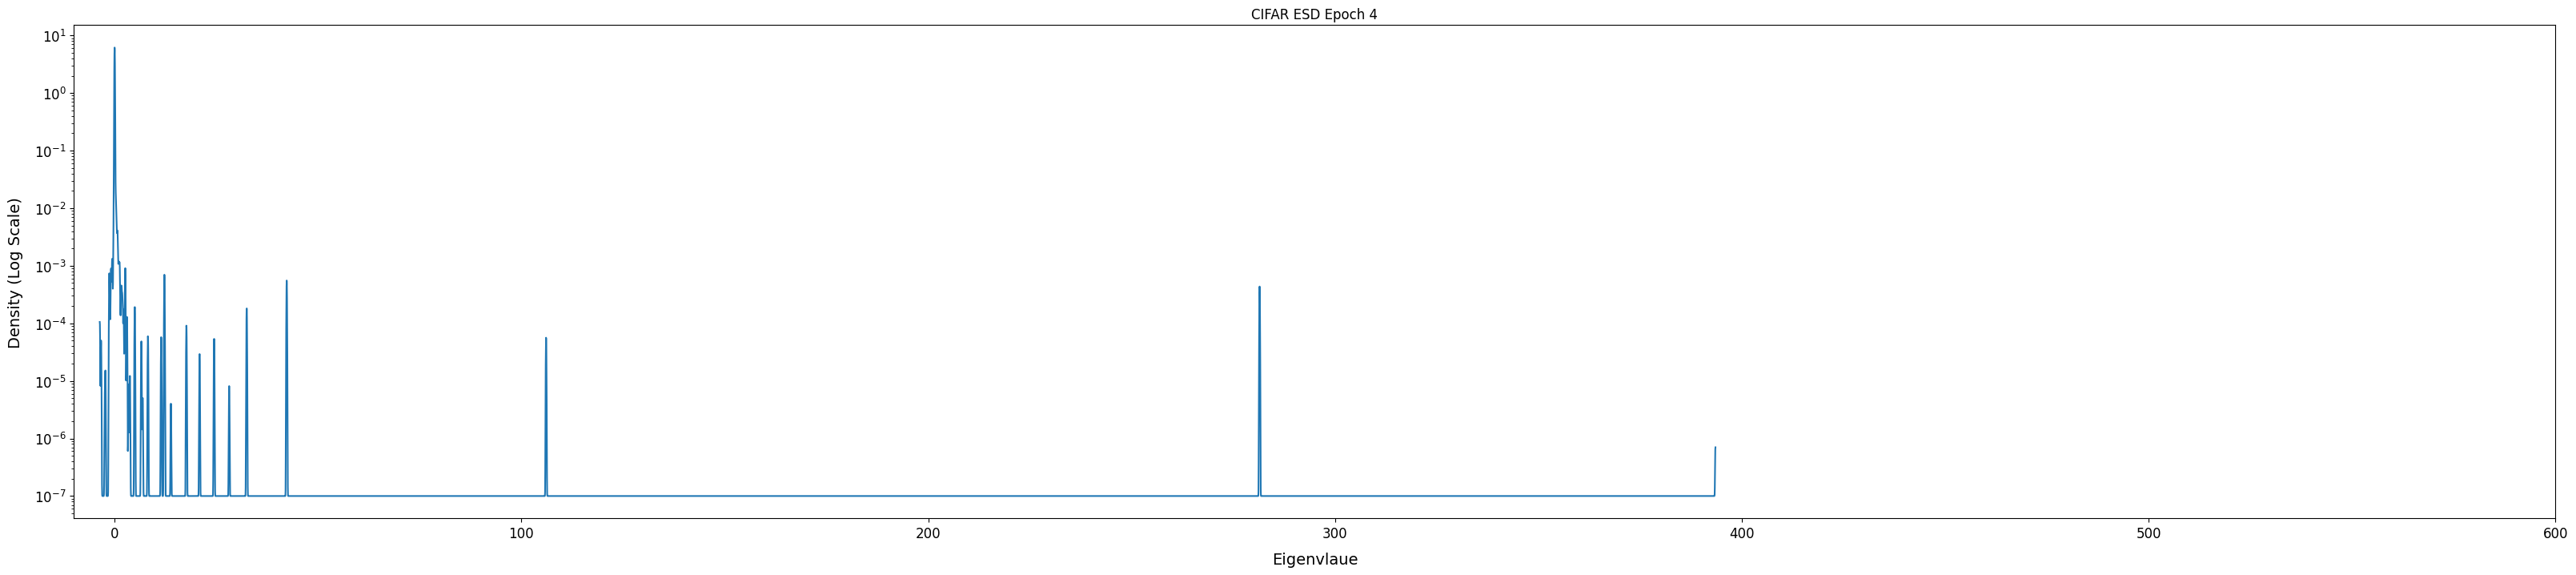

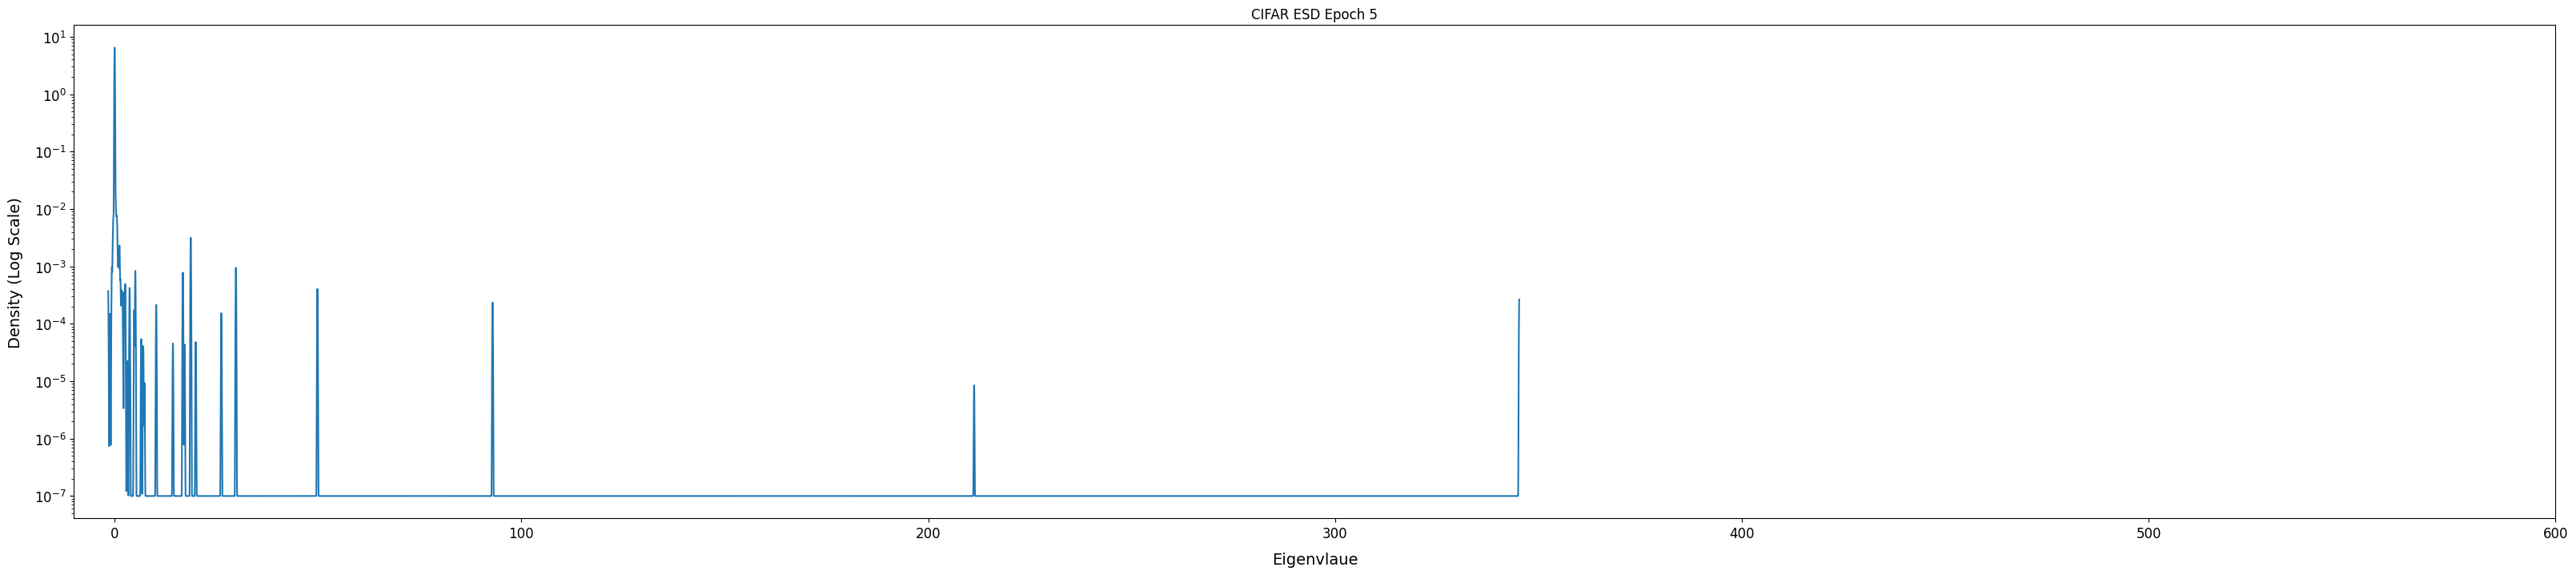

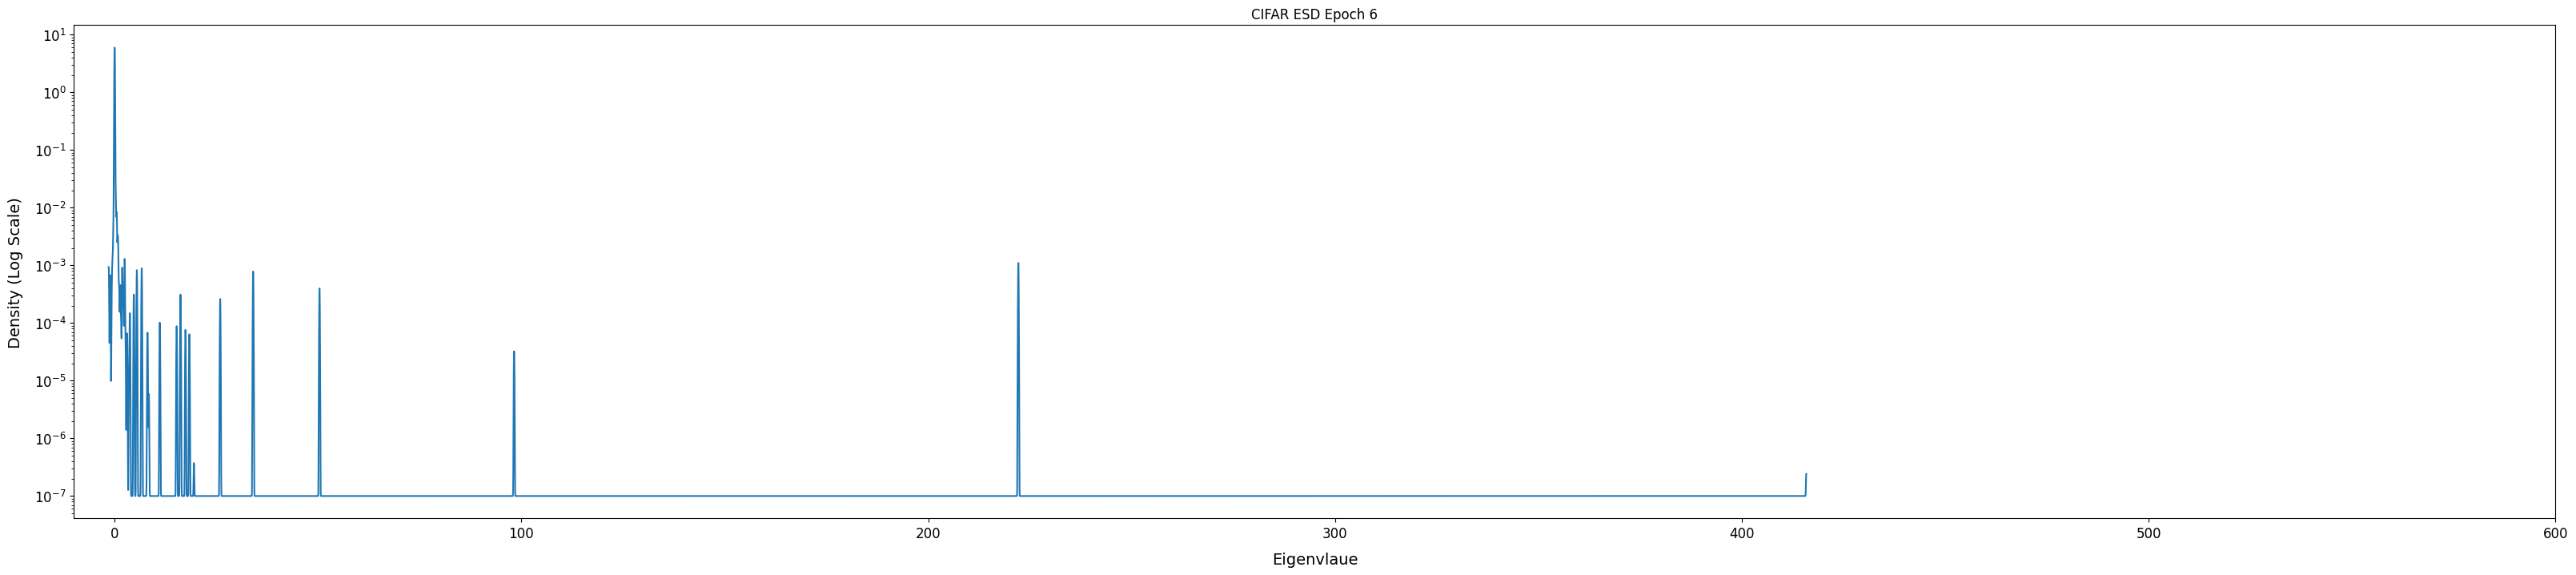

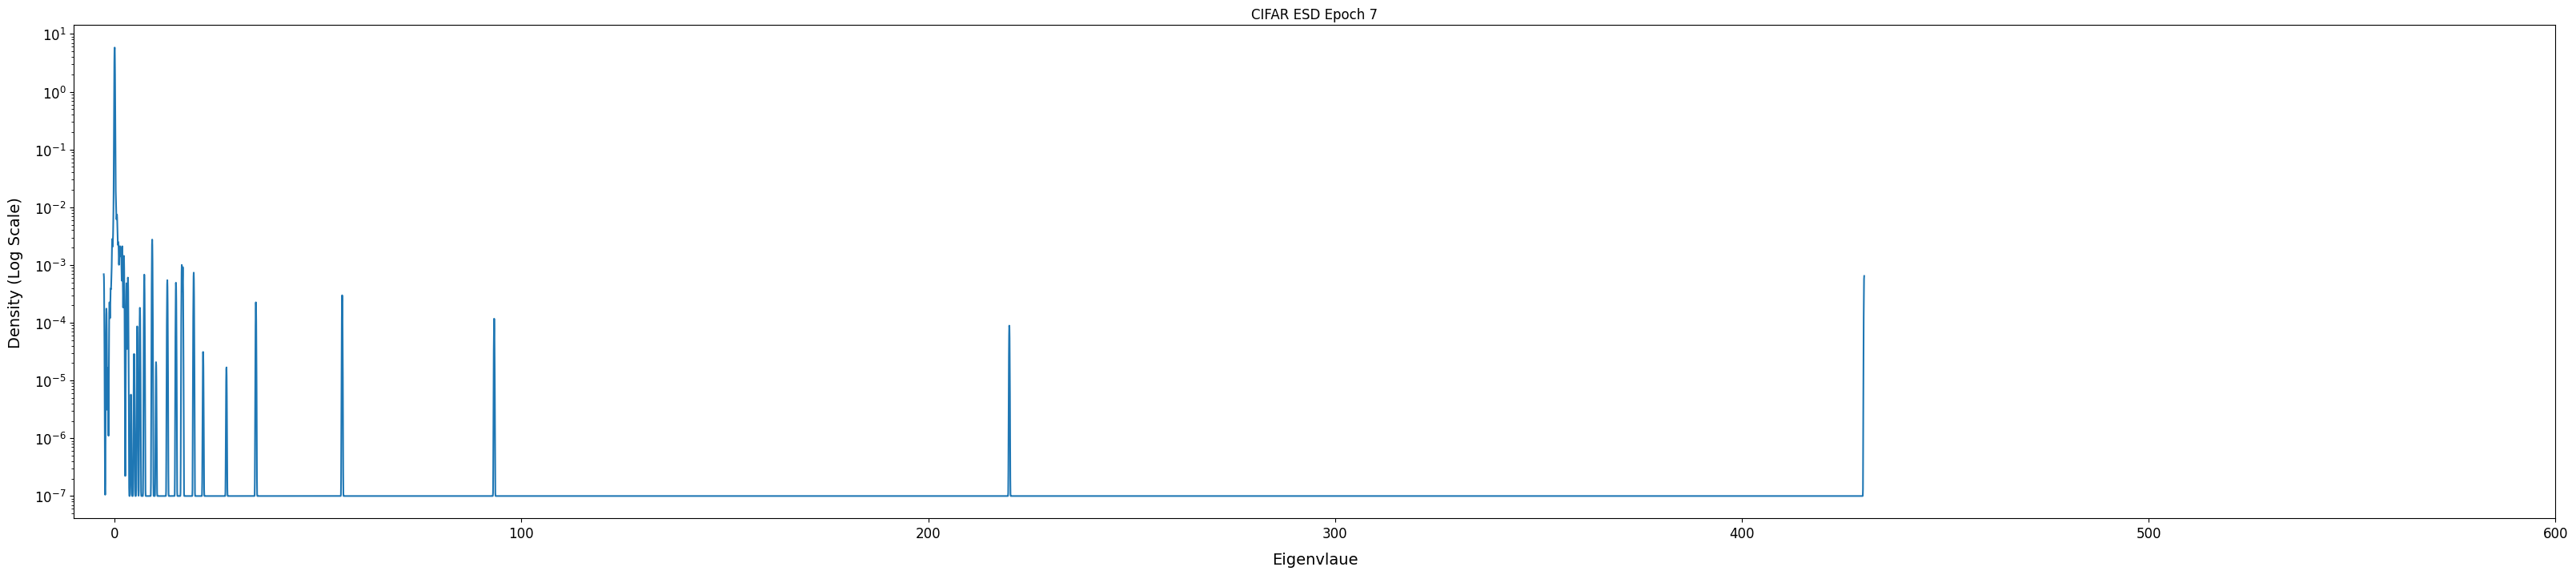

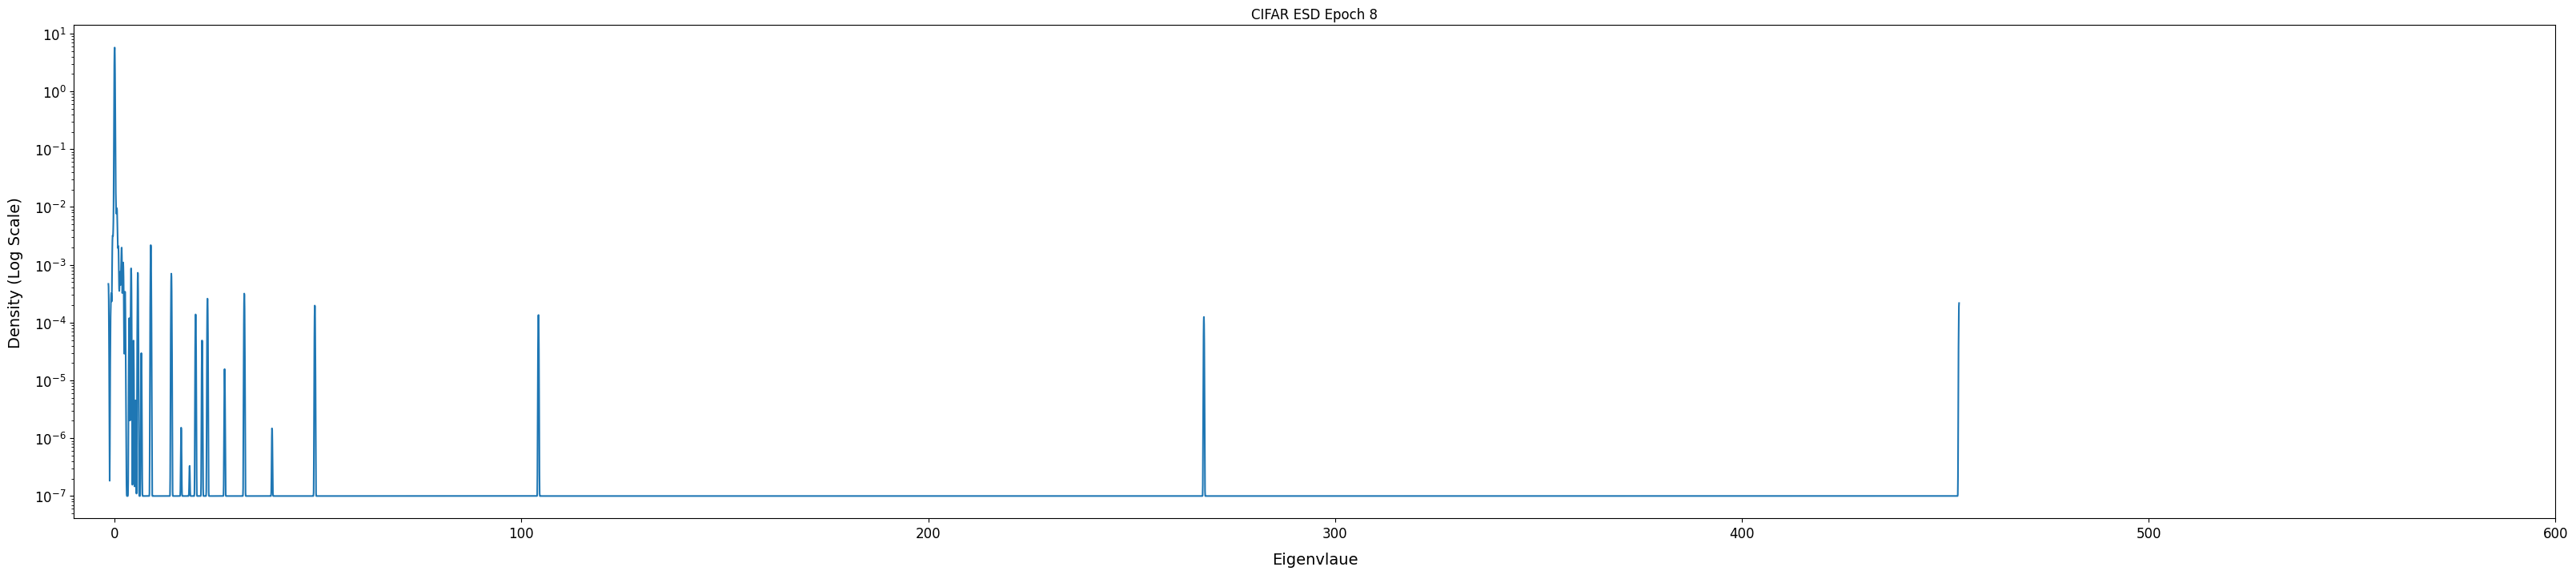

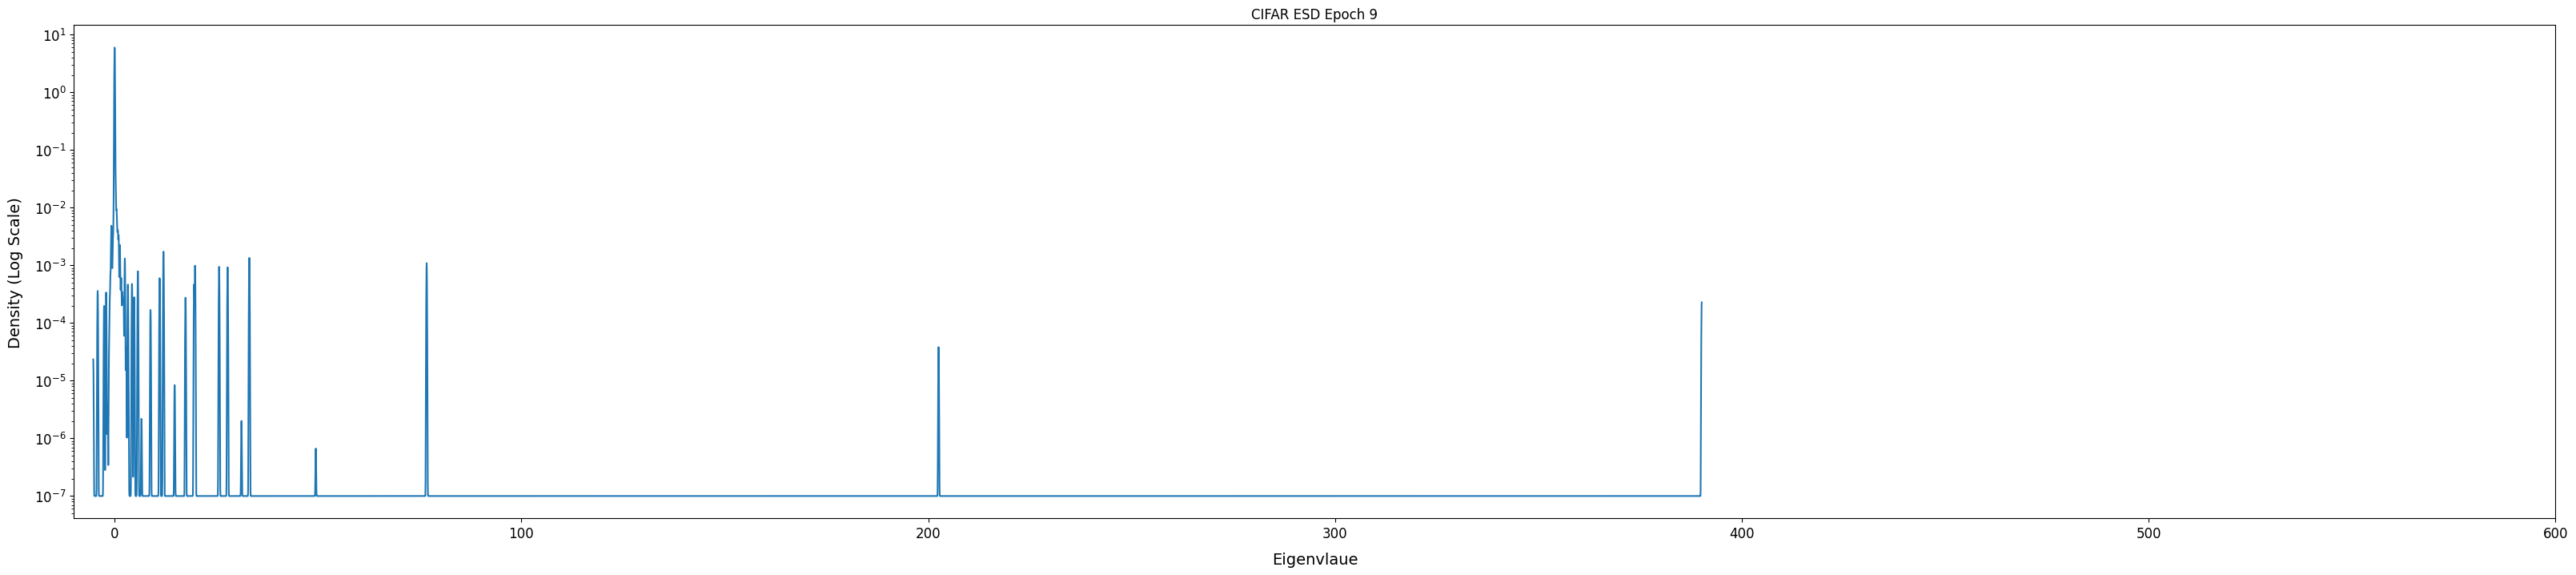

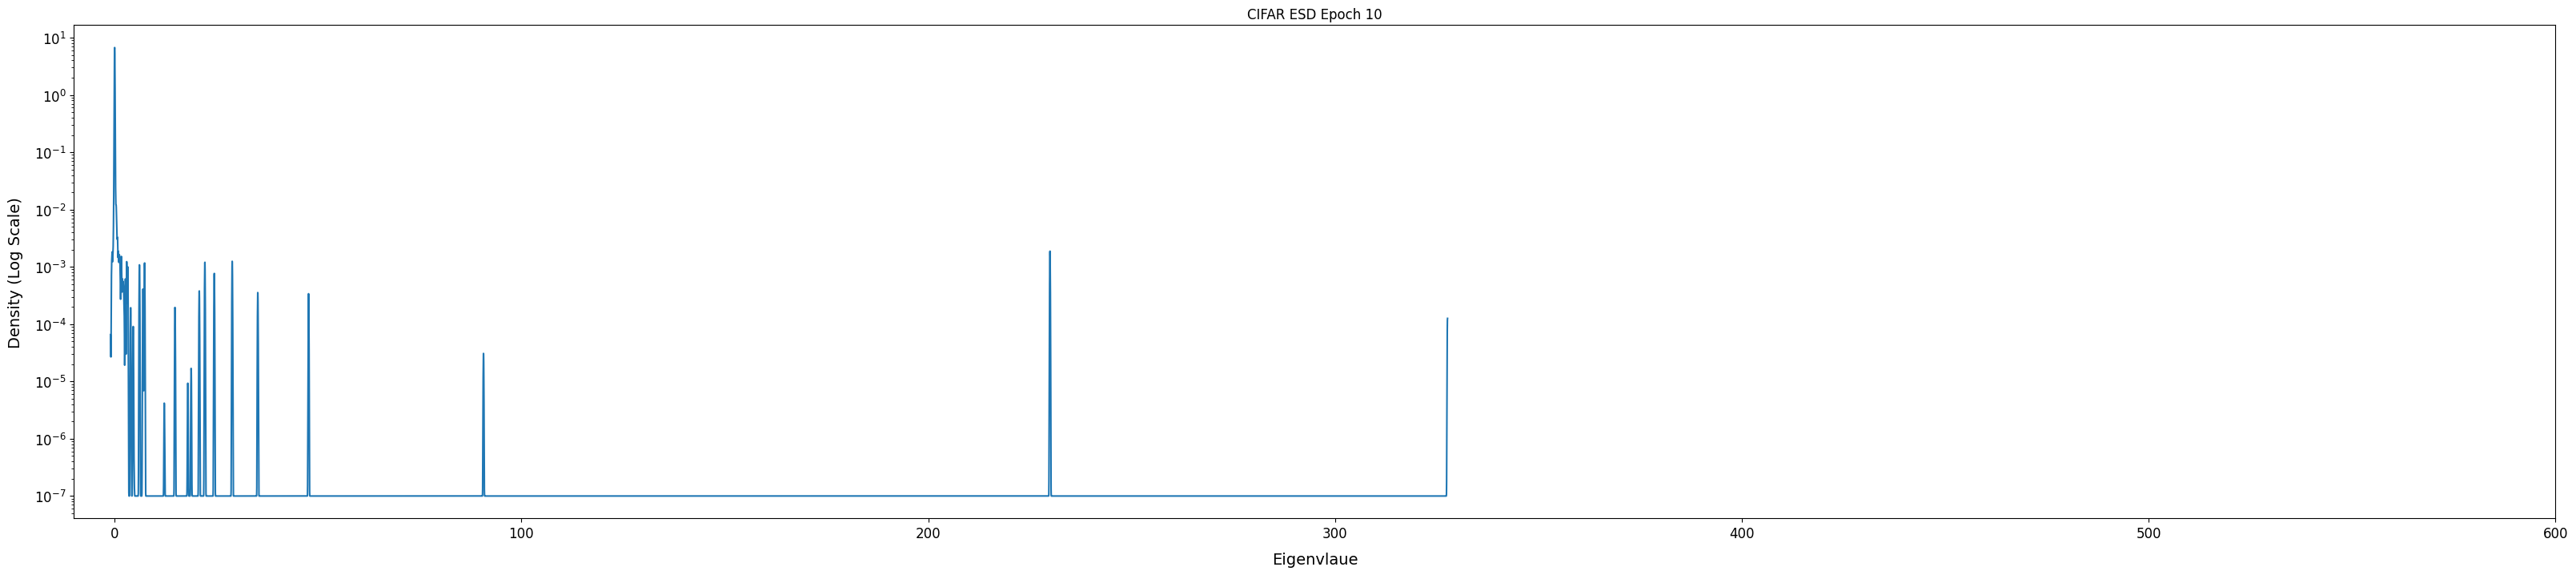

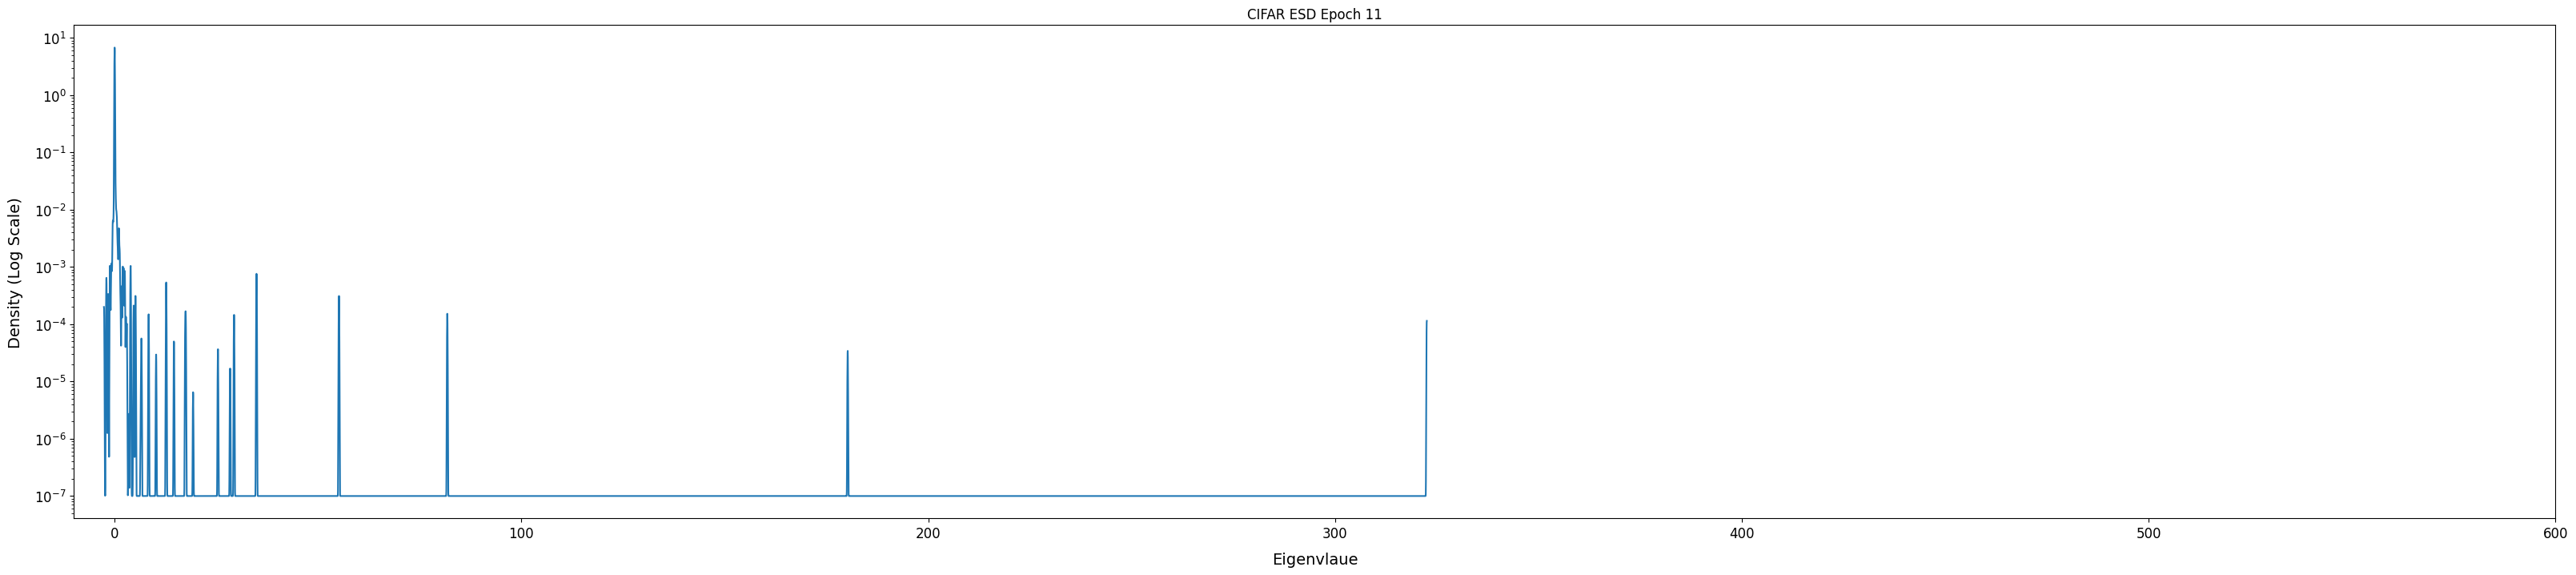

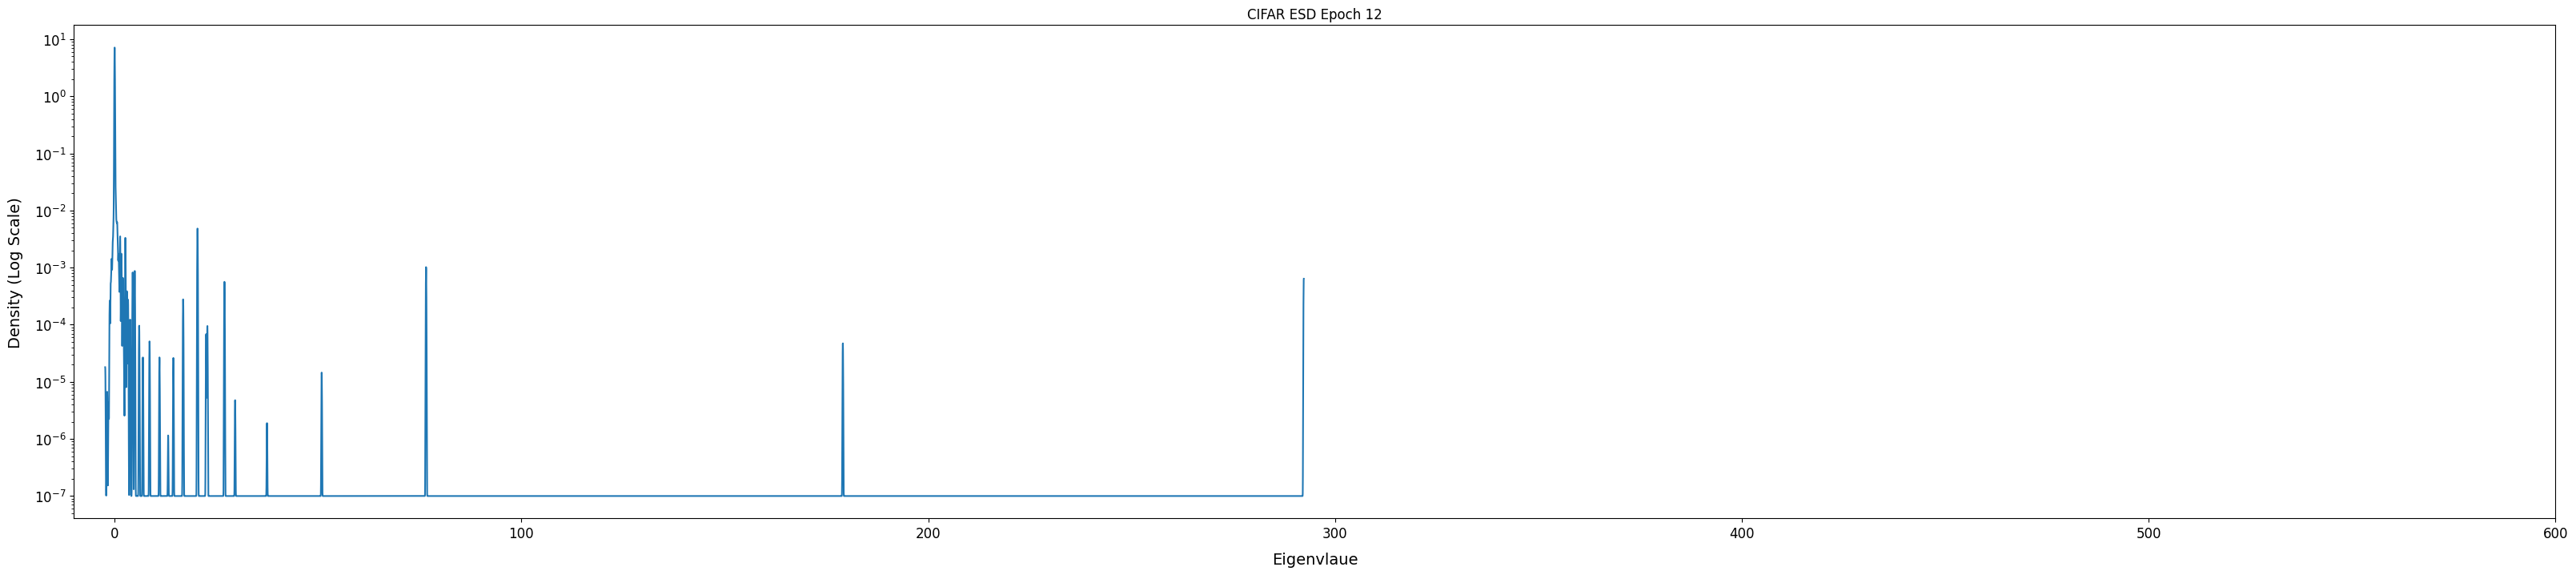

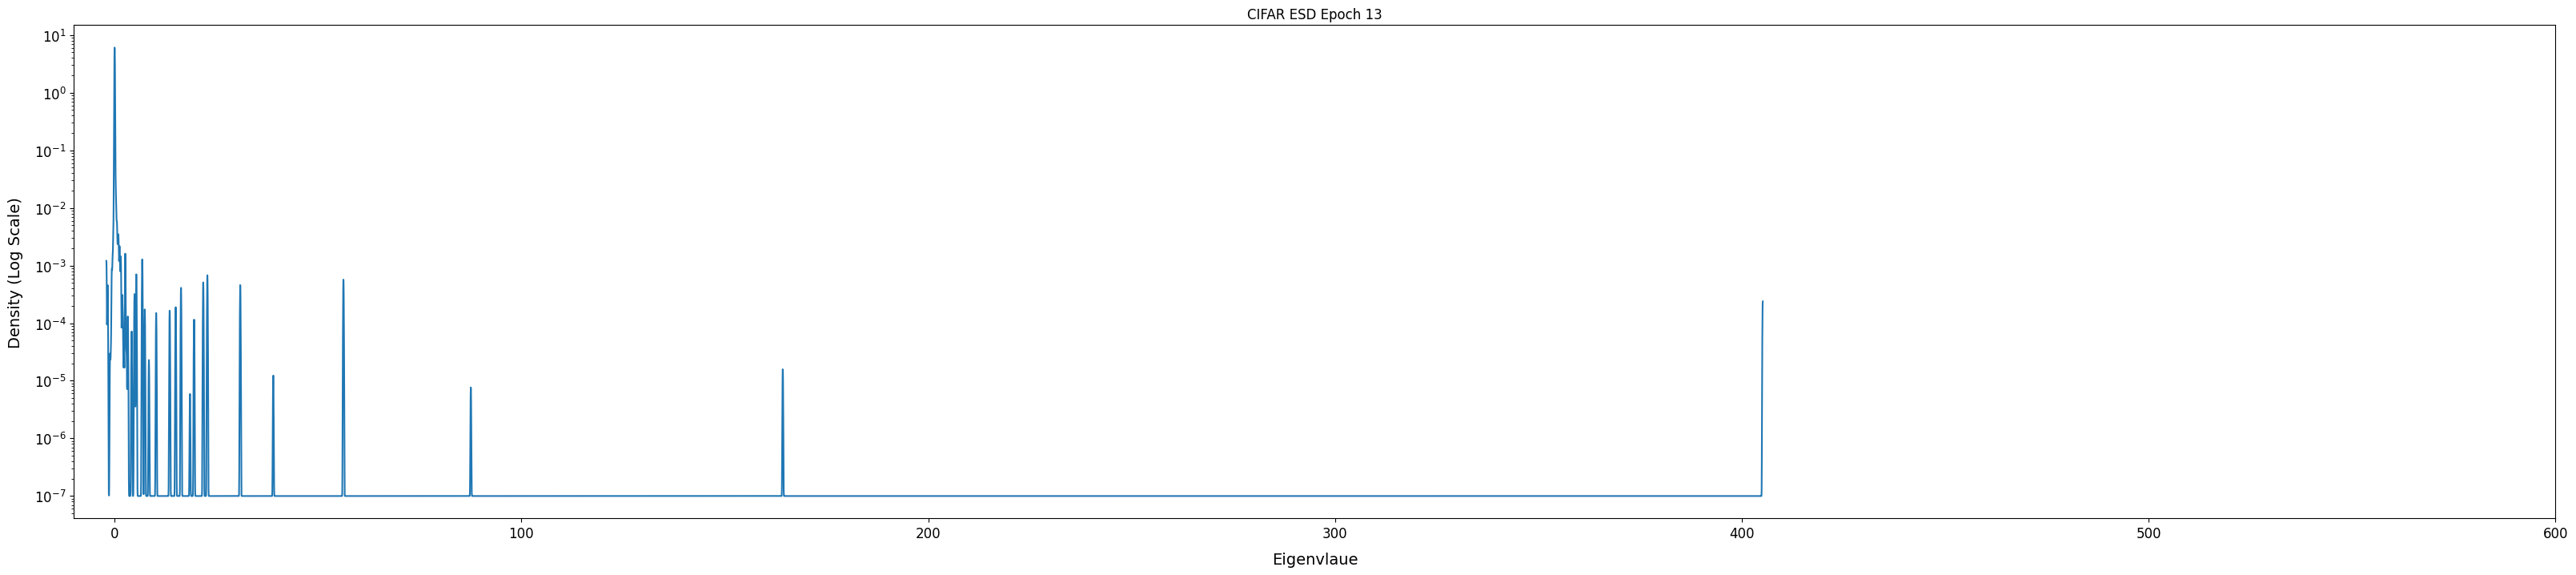

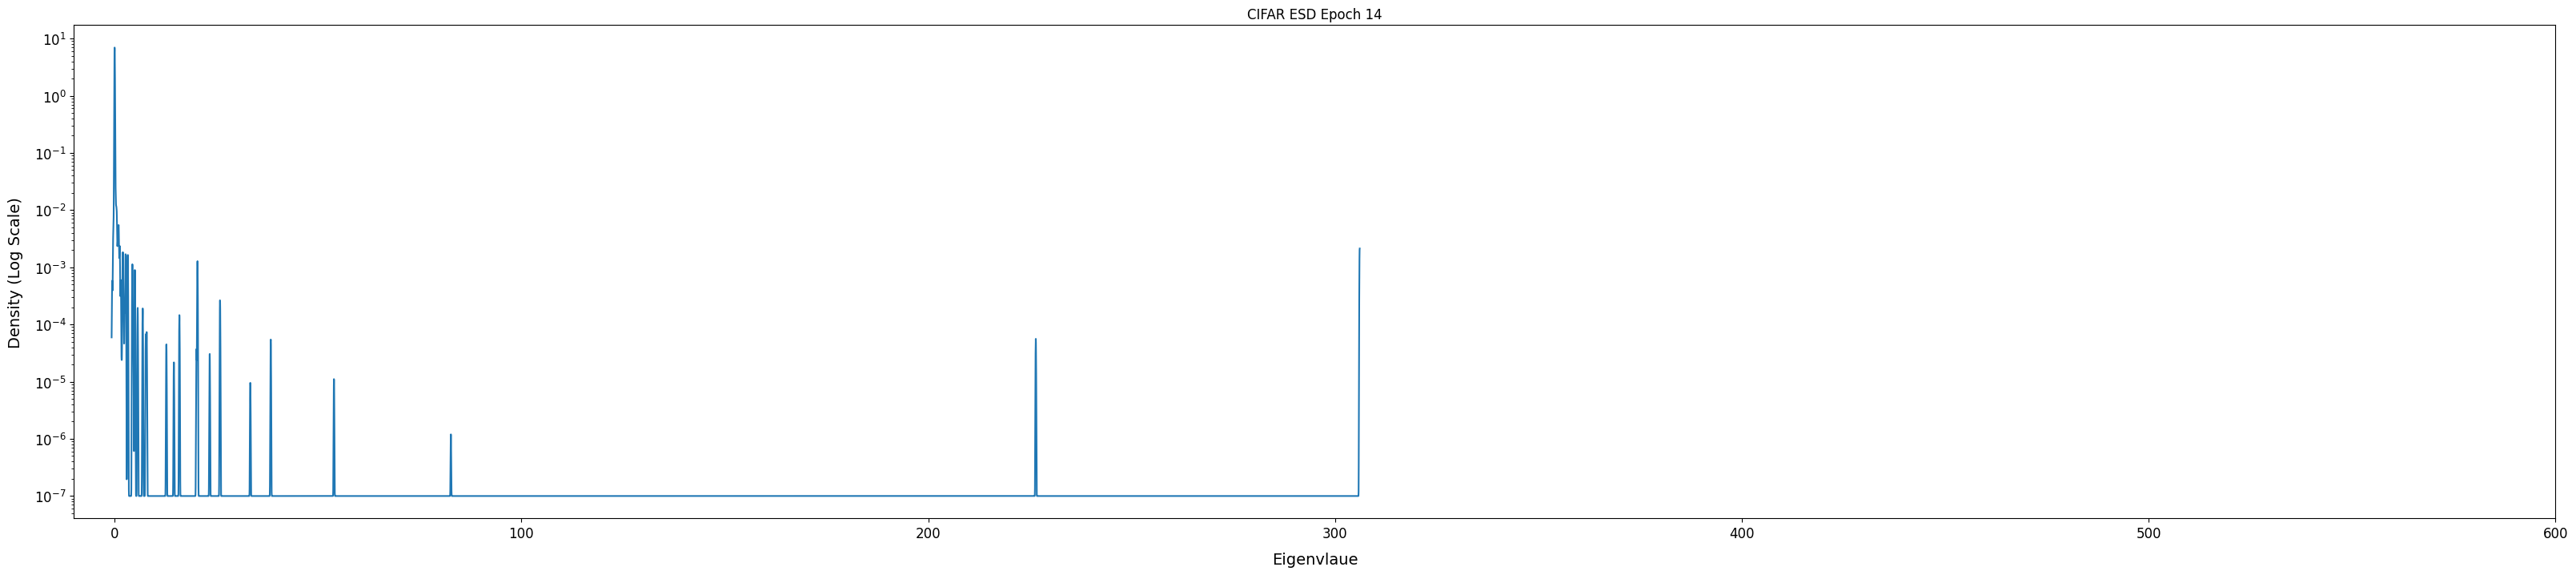

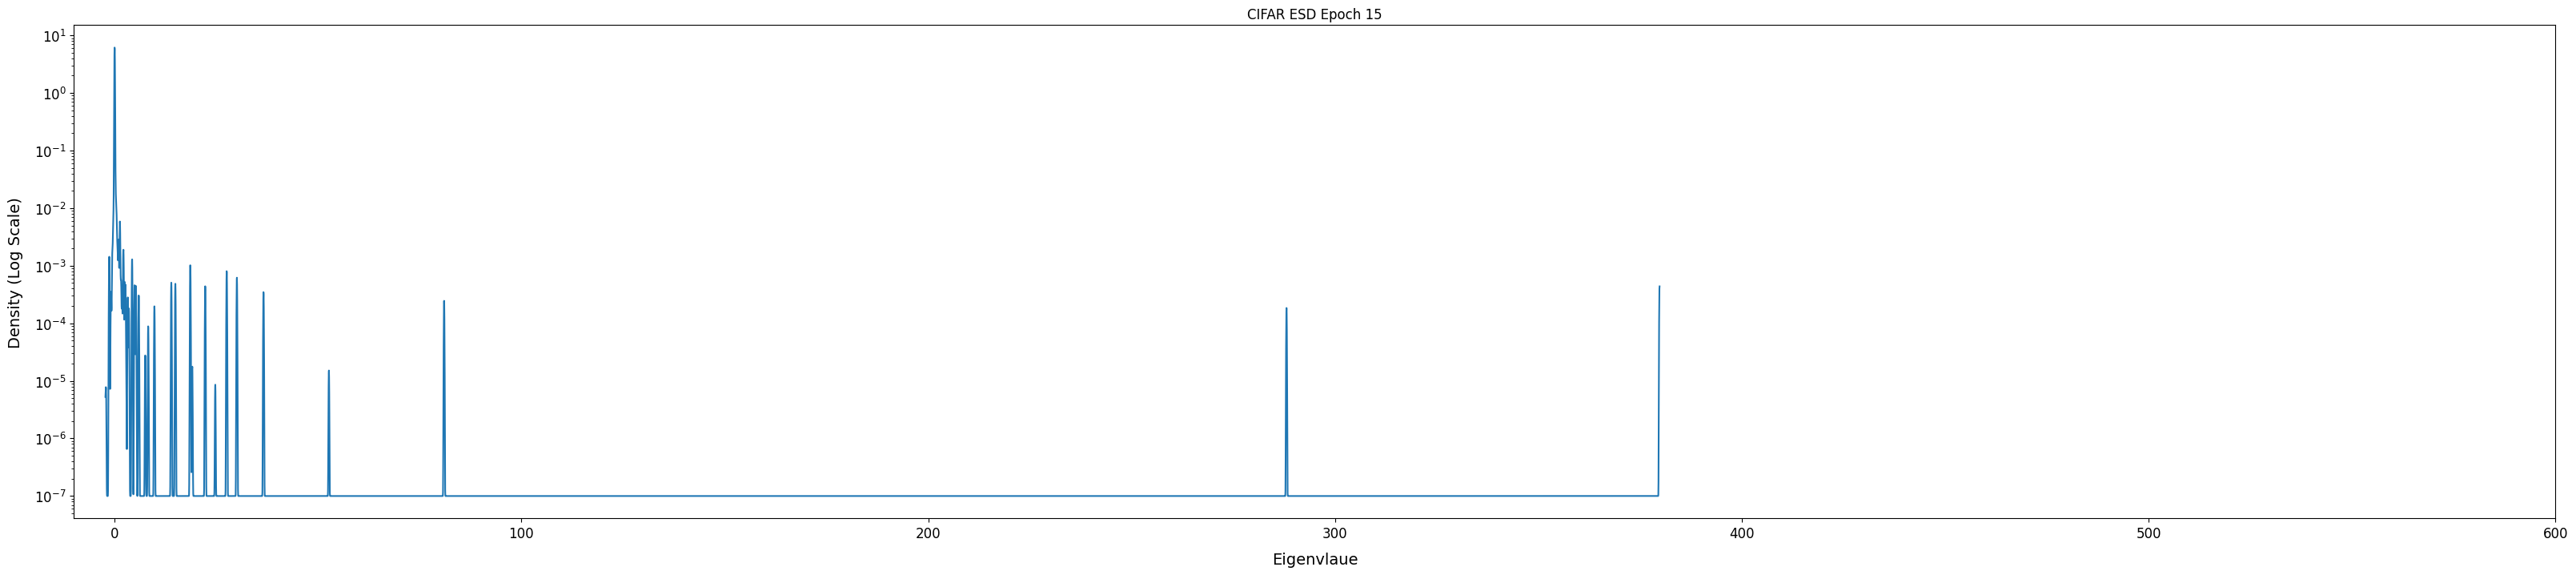

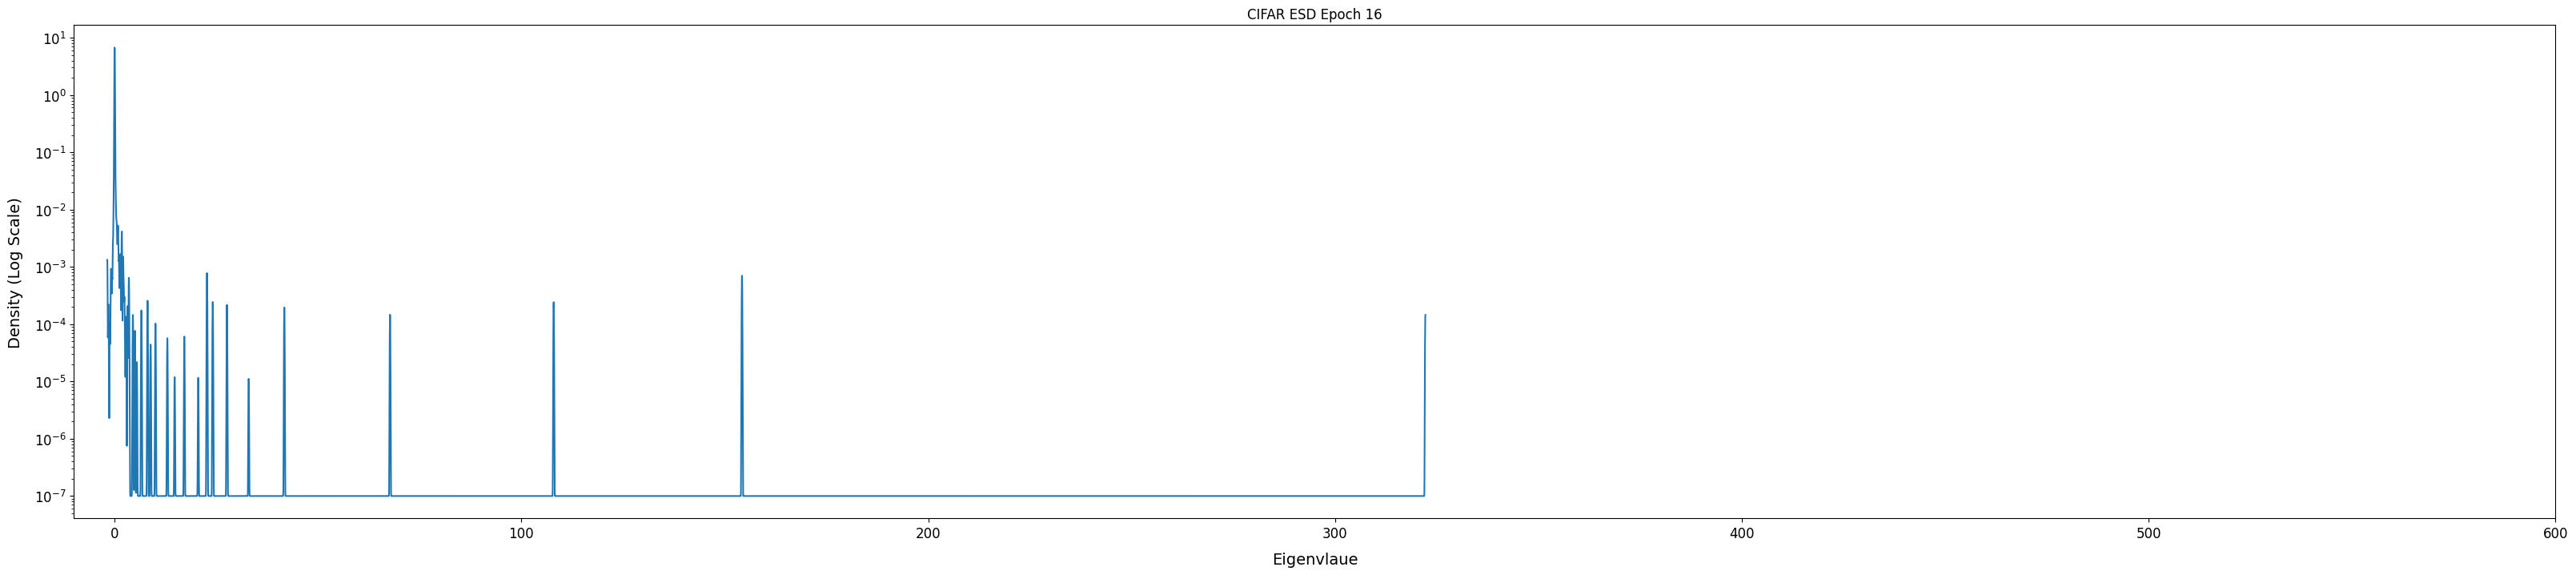

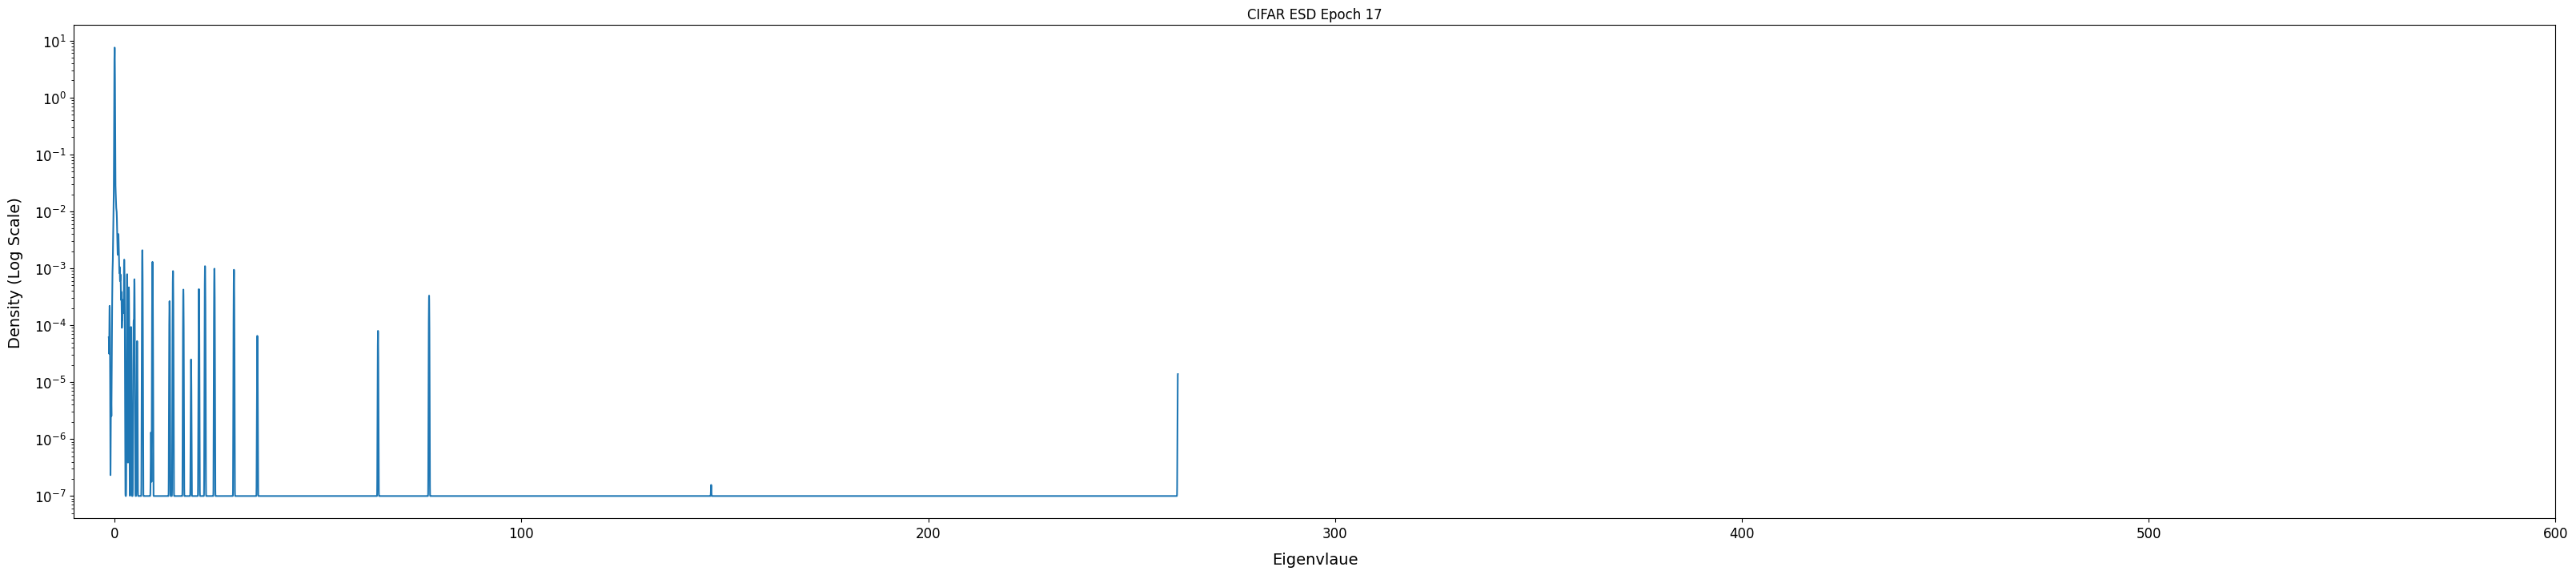

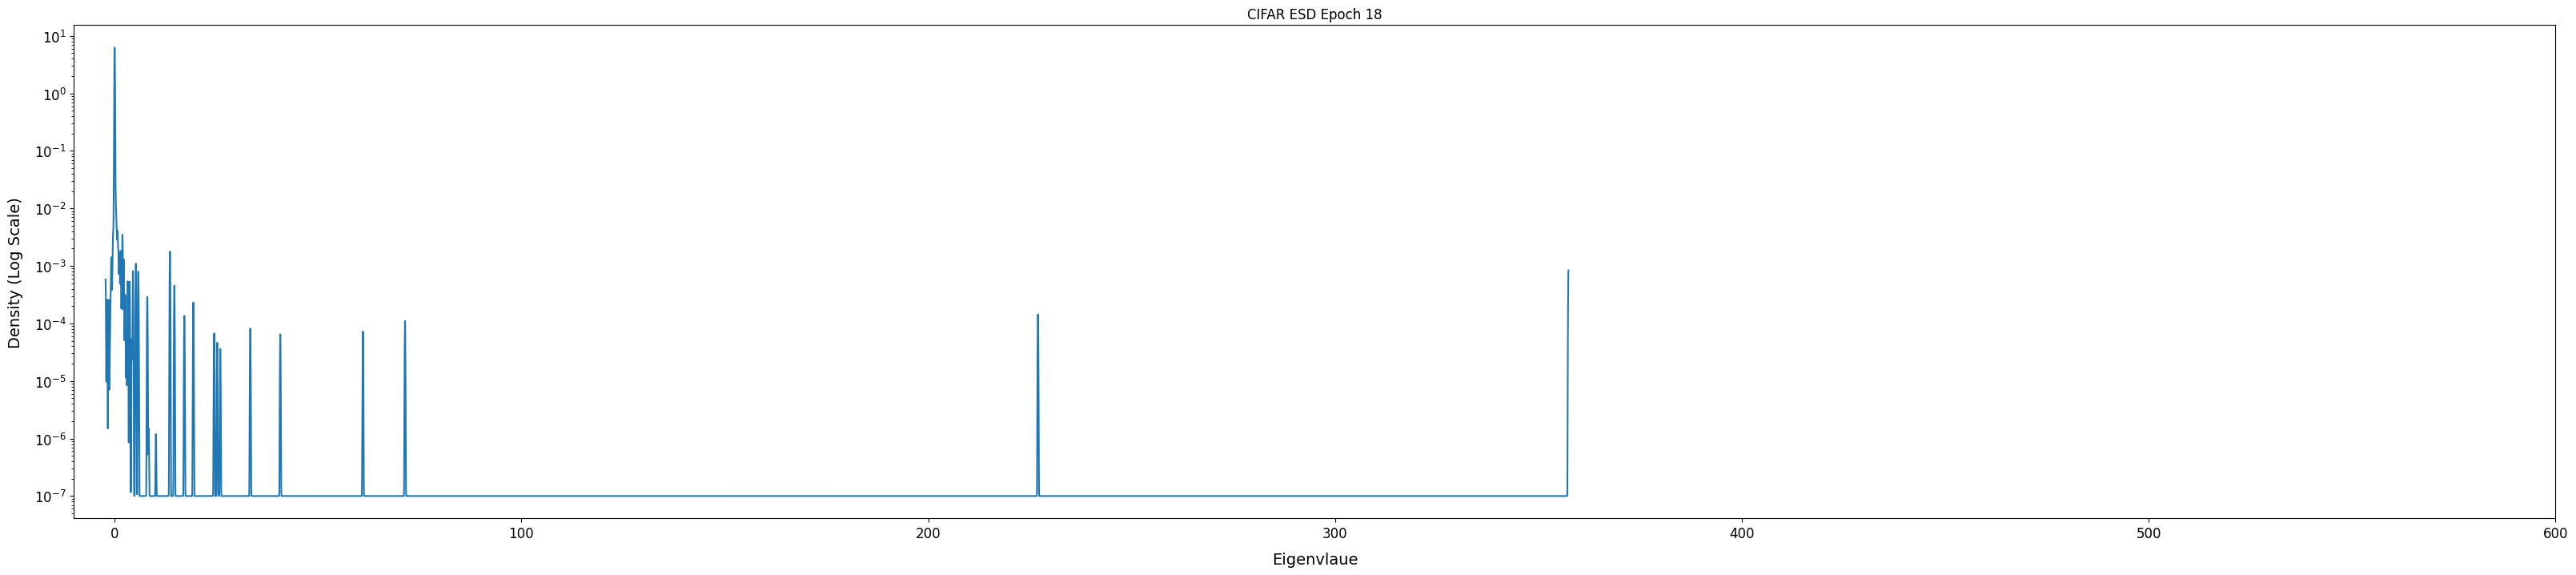

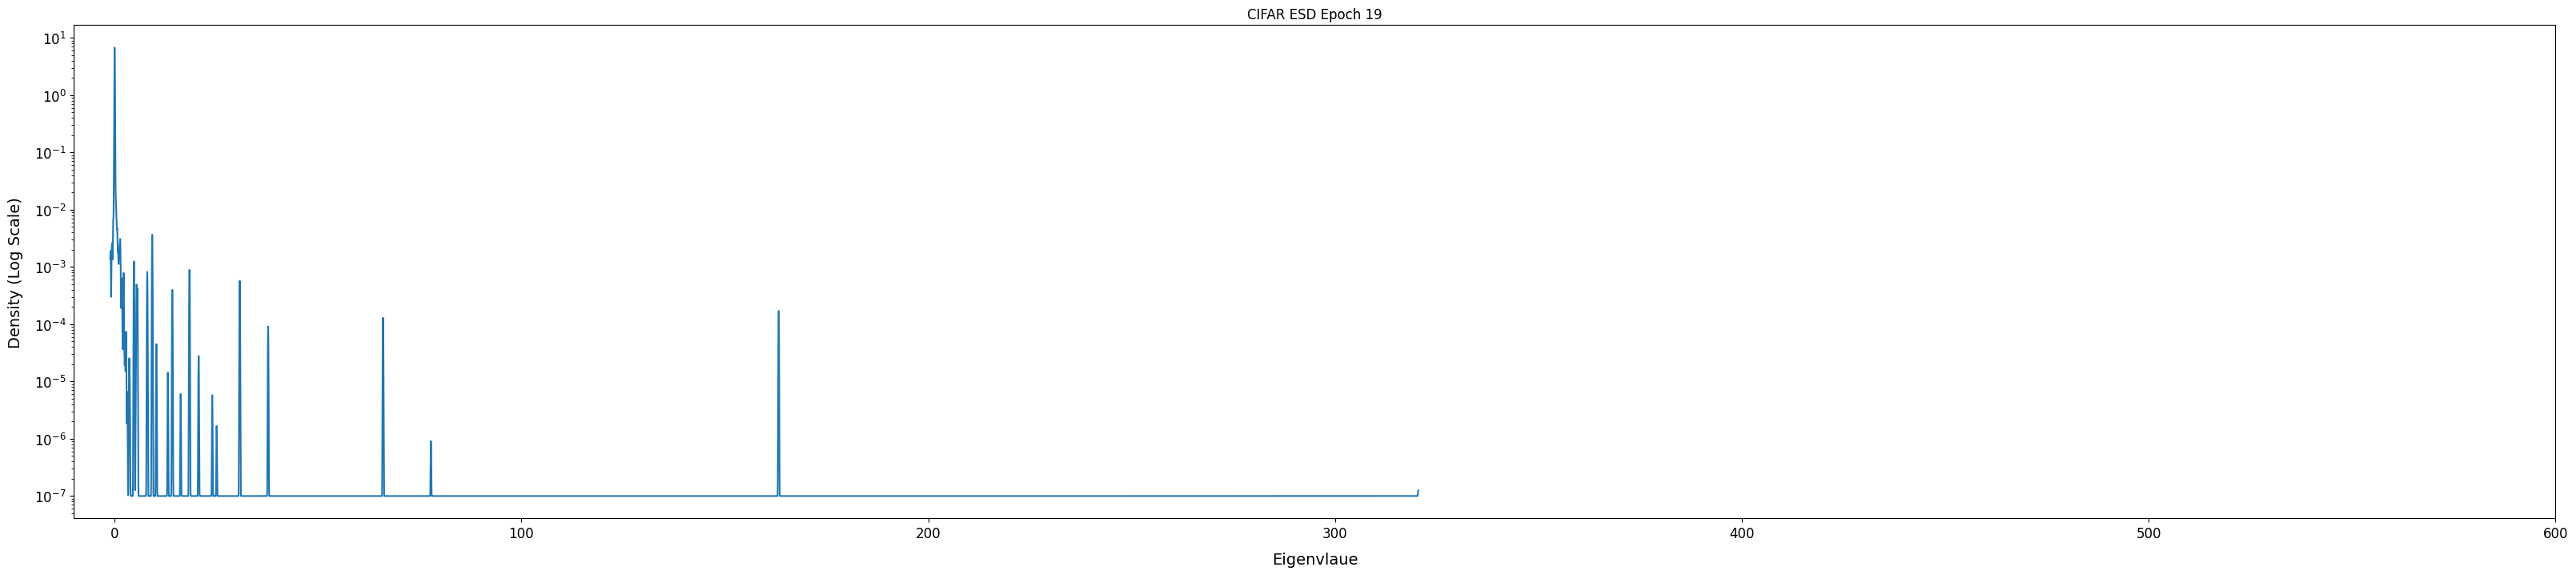

In [9]:
losses = []
test_losses = []
train_losses = []
for epoch in range(20):
    mh = Hessian_model(model, loader, criterion, n_classes=10)
    get_esd_plot(*mh.hessian_comp.density(), save_path=f'esd_images/cifar_esd_epoch_{epoch}.png', title=f'CIFAR ESD Epoch {epoch}', x_lims = (-10, 600))
    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(data)
        #output_test = model(test_X)
        loss = criterion(output, target)
        # loss_test = criterion(output_test, test_y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 500 == 0:
            output = model(val_x)
            loss_train = criterion(output, val_y)
            output = model(test_X)
            loss_test = criterion(output, test_y)
            print(f"Epoch {epoch}, step {i}, train_loss {loss.item()}, test_loss {loss_test.item()}")
            output_test = model(test_X)
            test_losses.append(loss_test.item())
            train_losses.append(loss_train.item())
    #print(loss.item())
    
    


Test accuracy: 0.6093


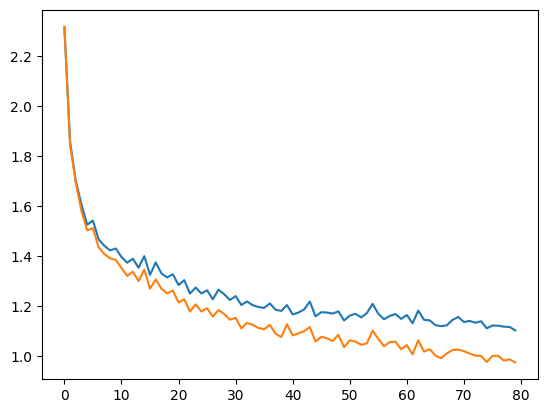

In [10]:
output = model(test_X)
_, predicted = torch.max(output, 1)
correct = (predicted == test_y).sum().item()
accuracy = correct / test_y.size(0)
print(f"Test accuracy: {accuracy}")
plt.plot(test_losses)
plt.plot(train_losses)
plt.show()

In [11]:
torch.save(model.state_dict(), "cifar_cnn_model_light.pth")

In [ ]:
model = Net().to(device)
#model.load_state_dict(torch.load("cifar_cnn_model_light.pth"))

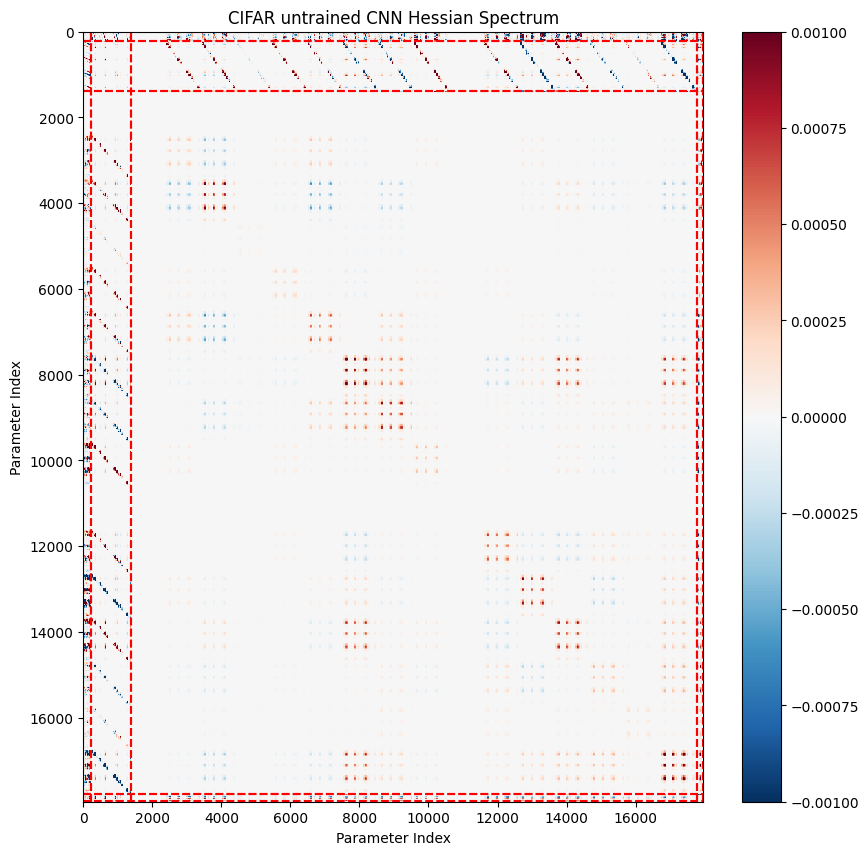

In [ ]:
#plot_hessian(model, criterion, x_samples, y_samples, figsize=(10, 10), title="CIFAR untrained CNN Hessian Spectrum")

In [ ]:
model.load_state_dict(torch.load("cifar_cnn_model_light.pth"))

<All keys matched successfully>

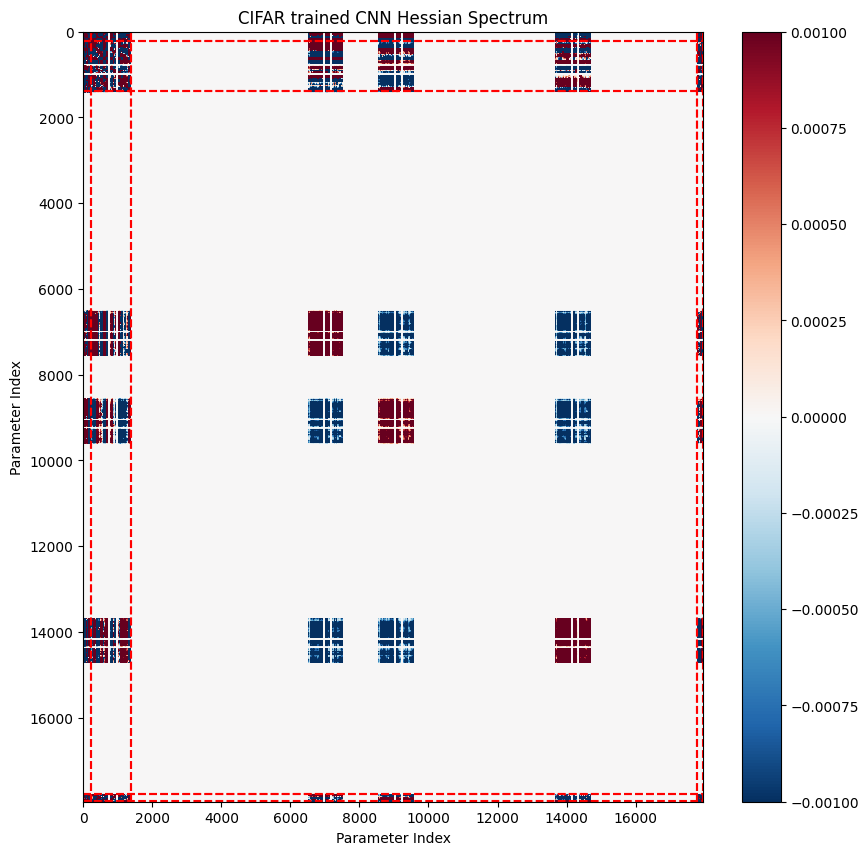

In [ ]:
plot_hessian(model, criterion, x_samples, y_samples, figsize=(10, 10), title="CIFAR trained CNN Hessian Spectrum")

In [ ]:
val_x = train_X[:50]
val_y = train_y[:50]

In [ ]:
#model.eval()
val_x.requires_grad = True
output = model(val_x)
loss = criterion(output, val_y)
loss.backward()

grad_vector = len(val_x)*torch.cat([param.grad.view(-1) for param in model.parameters()])
print("Found gradient vector")
hessian_matrix = len(val_x)*compute_hessian(model, criterion, val_x, val_y)
print("Foud hessian matrix")
#hessian_matrix = hessian_matrix.view(grad_vector.size(0), -1)

result = torch.matmul(hessian_matrix, grad_vector)

Found gradient vector


Foud hessian matrix


In [ ]:
print(torch.mean(result**2))

tensor(1.9291e+09)


In [ ]:
model__ = Net().to(device)
val_x.requires_grad = True
output = model__(val_x)
loss = criterion(output, val_y)
loss.backward()

grad_vector = len(val_x)*torch.cat([param.grad.view(-1) for param in model__.parameters()])
print("Found gradient vector")
hessian_matrix = len(val_x) * compute_hessian(model__, criterion, val_x, val_y)
print("Foud hessian matrix")
# hessian_matrix = len(val_x)*hessian_matrix.view(grad_vector.size(0), -1)

result = torch.matmul(hessian_matrix, grad_vector)

Found gradient vector
Foud hessian matrix


In [ ]:
print(torch.mean(result**2))

tensor(121.6287)


In [ ]:
#model.eval()
val_x.requires_grad = True
output = model(val_x)
loss = criterion(output, val_y)
loss.backward()

grad_vector = len(val_x)*torch.cat([param.grad.view(-1) for param in model.parameters()])
print("Found gradient vector")
hessian_matrix = len(val_x)*compute_hessian(model, criterion, val_x, val_y)
print("Foud hessian matrix")
#hessian_matrix = hessian_matrix.view(grad_vector.size(0), -1)

result = torch.matmul(hessian_matrix, grad_vector)

In [ ]:
num_batches = 4
loader = []
for i, (data, target) in enumerate(dataloader):
    if i == num_batches:
        break
    loader.append((data, target))

/teamspace/studios/this_studio/DeepHessian/PyHessian/density_plot.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


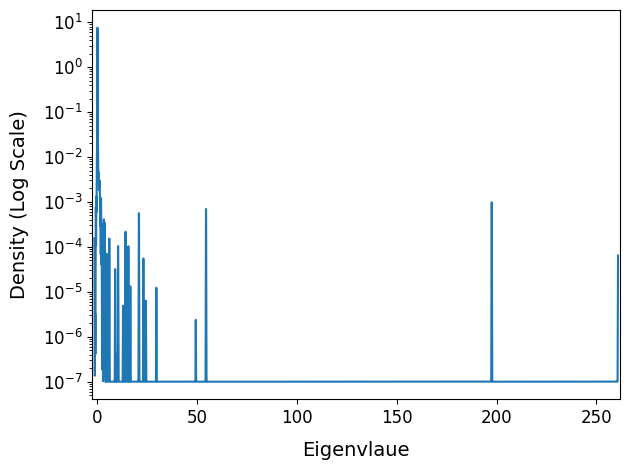

In [ ]:
%matplotlib inline
mh = Hessian_model(model, loader, criterion, n_classes=10)
get_esd_plot(*mh.hessian_comp.density())